In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.io
import random
import datetime
import time
from sase1d_input_part501 import sase 

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 3953.60it/s]


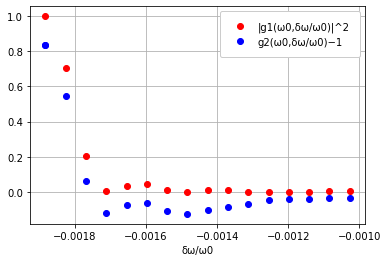

0.8372541289941611 0.9999999999999998
0.5458900040540562 0.7029983891801279
0.06221476555245542 0.20529385061911493
-0.11948783909887573 0.006166479209904869
-0.07445935907306778 0.03616343893167901
-0.062498358700881496 0.044607838859873114
-0.10810440571373459 0.009627261307951914
-0.1254538974009315 0.0013231581190082638
-0.10547743468974857 0.01127371699254549
-0.08409142805675451 0.008025028012136557
-0.06659822905538293 0.0013601941025325514
-0.0481356765188673 0.0021153677231352426
-0.039117504099861256 0.00104988555609933
-0.03811865451116914 0.001145022405389703
-0.03646073295358687 0.006978910195497498
-0.03676023320336086 0.007584675157894468
135.3553 minutes


In [2]:
    ##method to calculate g1, g2
    from joblib import Parallel, delayed
    from taper_output_func import taper_output2
    from sase1d_input_part501 import sase
    from tqdm import tqdm

    unduK=np.ones(200)*3.5
    runs = 2000
    deltaw = np.array([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]) ##put integers of form 2k, where deltaw is of the form 2k*df. ex: -100,-50,0,50,100
    x=deltaw.shape[0]
    num1 = np.zeros((x,runs),dtype=complex)
    #print(num1)
    dec1a = np.zeros((x,runs))
    dec1b = np.zeros((x,runs))
    num2 = np.zeros((x,runs))
    dec2a = np.zeros((x,runs))
    dec2b = np.zeros((x,runs))
    #start with g(freq[100]=826.549 about= omega, 2*df)
    omega = 826.5507127999223
    n = 5  ##scaling factor when adding in zeros to FFT: Ex: 201 to 1005 means n=5.
    C=0
    ##changes in 11/5
    spectrumTOTAL = np.zeros((3005, runs),dtype=complex) ##manually enter size of spectrum array
    spectrumSUM = np.zeros(3005,dtype=complex)
    ##end
    
    start = time.time()
    #with Pool(multiprocessing.cpu_count()) as p:
         #r = zip(*p.map(taper_output2 range(runs,runs+1)))  
        ##p.close()
        ##p.join()
    r = Parallel(n_jobs=-1)(delayed(taper_output2)(unduK) for i in tqdm(range(runs))) #This method works -- verified!
    #spectrum1, field1, freq1, s_steps1 = zip(*r)
    spectrum, field, freq1, s_steps1 = zip(*r)
    
#    print(type(spectrum1))
#    print(type(field1))
#    print(type(freq1))
#     print(spectrum1)
#     print(spectrum1[0])
#     print(spectrum1[0][:2])
#     print(freq1)
#     print(freq1[0])
    
    #spectrum = np.asarray(spectrum1)
    #field = np.asarray(field1)
    #freq1a = np.asarray(freq1)
    freq = freq1[0]
    s_steps = s_steps1[0]
    
#     spectrum = spectrum1a
#     field = field1a
#     freq = freq1a[0]
    
    
    
    
    for h in tqdm(range(runs)): 
 
        for b in range(spectrumSUM.size):
            spectrumSUM[b] = spectrumSUM[b] + spectrum[h][b]
#        print(spectrumSUM)
        for f in range(spectrumSUM.size):
            spectrumTOTAL[f][h] = spectrum[h][f]
#         print(type(spectrumTOTAL))
#         print(spectrumTOTAL.shape)
#         print(spectrumTOTAL)
        
    for k in range(freq.shape[0]):
        freq[k]=(freq[k]-omega)/omega
#     print(freq.shape)
#     print(freq)
        
#     print(spectrumSUM)
#     print(spectrumTOTAL)
            
    maxV = spectrumSUM[0]
    indexV = 0
#     print(maxV)
#     print(spectrumSUM.size)
    for i in range(spectrumSUM.size):
        if spectrumSUM[i] > maxV:
            maxV = spectrumSUM[i]
            indexV = i
            C = indexV
    
    
#     plt.plot(freq, spectrumSUM) #may need to change spectrum indexing
#     plt.xlabel('δω/ω0')
#     plt.ylabel('spectrumSUM power (W)')
#     plt.show()
    
    
    for r in tqdm(range(runs)):

        #C = indexV
        for d in range(x):
            a = int(deltaw[d]/2)
            #C = int((s_steps+1)*n/2) ##with expansion of zeros from FFT
            #print(C)
            #print(spectrum[C], spectrum[C+1], spectrum[C-1])
            num1[d][r] = spectrumTOTAL[C-a][r]*np.conj(spectrumTOTAL[C+a][r])
            dec1a[d][r] = (np.absolute(spectrumTOTAL[C-a][r]))**2
            dec1b[d][r] = (np.absolute(spectrumTOTAL[C+a][r]))**2
            num2[d][r] = pow(np.absolute(spectrumTOTAL[C-a][r]),2)*pow(np.absolute(spectrumTOTAL[C+a][r]),2)
            dec2a[d][r] = pow(np.absolute(spectrumTOTAL[C-a][r]),2)
            dec2b[d][r] = pow(np.absolute(spectrumTOTAL[C+a][r]),2)

    NUM1 = np.zeros(x,dtype=complex) #2D arrays for each dif delta(w) value/datapt
    DEC1a = np.zeros(x)
    DEC1b = np.zeros(x)
    NUM2 = np.zeros(x)
    DEC2a = np.zeros(x)
    DEC2b = np.zeros(x)
    #modify below to adjust for arrays
    for t in range(x):
        NUM1[t] = np.sum(num1[t,:],dtype=complex)/runs #sum across horizontal 1d array for constant deltaw for different runs
        DEC1a[t] = np.sum(dec1a[t,:])/runs
        DEC1b[t] = np.sum(dec1b[t,:])/runs
        NUM2[t] = np.sum(num2[t,:])/runs
        DEC2a[t] = np.sum(dec2a[t,:])/runs
        DEC2b[t] = np.sum(dec2b[t,:])/runs

    g1 = np.zeros(x, dtype=complex)
    g2 = np.zeros(x)
    for k in range(x):
        g1[k] = NUM1[k]/((DEC1a[k]*DEC1b[k])**0.5)
        g2[k] = NUM2[k]/(DEC2a[k]*DEC2b[k])
        
    plt.figure() 
    
    ##5/1 edits: add in legends, etc - changed the below lines
    #print(freq[C])
    #print((np.absolute(g1[0]))**2)
    plt.plot(freq[C],(np.absolute(g1[0]))**2, 'ro', label='|g1(ω0,δω/ω0)|^2')
    for t in range(x):
        if(t!=0):
            plt.plot(freq[C+2*t],(np.absolute(g1[t]))**2,'ro')
        
    plt.xlabel('δω/ω0')

    plt.plot(freq[C], g2[0]-1, 'bo', label='g2(ω0,δω/ω0)−1')
    for s in range(x):
        plt.plot(freq[C+2*s],g2[s]-1,'bo')
    
    leg = plt.legend();
    plt.legend(loc='upper right', fancybox=True, framealpha=1, borderpad=1)
    plt.grid()
    plt.show()
    
    for y in range(g1.shape[0]):
        print(g2[y]-1, (np.absolute(g1[y]))**2) ##print values of g1, g2 in table
    
    end = time.time()
    print('{:.4f} minutes'.format((end-start)/60))
    
#     print(x)
#     print(type(g1))
#     print(type(g2))
#     print(g2.shape)
#     print(g2)
#     print(type(freq))
#     print(len(freq))
#     print(freq)
#     print(freq[0])
#     print(C)
    
    #return g1, g2

In [5]:
import multiprocessing
print(multiprocessing.cpu_count())

16
